# Superconductivity Individual Analysis (New calibration template)

Use this template to carry out the analysis tasks for the experiment.  For reference, here are links to recommended Python resources: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

We will be making use of both the [Uncertainties](https://pythonhosted.org/uncertainties/) and [LMFit](https://lmfit.github.io/lmfit-py/) packages in this notebook.

#### Updated to show revised analysis procedures

As of February 2024, use the steps outlined below if you
* Have taken data with the LabVIEW based Chart Recorder application.
* Wish to use the ITS-90 coefficients to calculate temperature from the pressure data.

In [1]:
# Run this cell with Shift-Enter, and wait until the asterisk changes to a number, i.e., [*] becomes [1]
import numpy as np
import scipy.constants as const
import uncertainties as unc
import uncertainties.unumpy as unp
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 9.0,6.5  # Roughly 9 cm wde by 6.5 cm high
mpl.rcParams['font.size'] = 11.0 # Use 11 point font

## Prior to working on this notebook:

1. Extract the transition points ($I$ through the 5 ohm sensing resistor in voltage units) versus pressure readings ($P$ in voltage units scaled to mmHg, called "torr") from the data scans. Make a CSV spreadsheet file with two columns: "P (torr)", "I (volts)"

2. Calculate the temperature in on of two ways:

    a. Use the "1958 He Scale of Temperatures” booklet, or the [online calculator from Quantum Design](https://qdusa.com/support/helium_vapor_pressure.html).
    
    b. Opt to create a function from the official polynomial fit described in the [International Temperature Scale of 1990 (ITS-90)](https://courses.washington.edu/phys431/superconductivity/ITS-1990_McGlashan_JChemThermo_1990.pdf), to convert the pressure readings to temperature $T$ (K) in the steps below.


### Then...
4. Import the CSV file of pressure/temperature versus transition points in volts across the current-sense resistor into the directory containing this notebook.

5. Create a calibration function to convert measured voltage across the current-sense resistor to magnetic field, using the magnet calibration curve in figure 5 of the (revised in 20204) instructions.

6. Apply the calibration function to obtain the transition points in terms of magnetic field in gauss.

7. Conduct a similar process if using the ITS-90 scale coefficients to obtain the temperature from the pressure reading.  (If you have already done this by hand, skip this step.)

8. Plot $H_c$ vs. $T$.

9. Fit the above using two different methods: (A) linearize the data, then fit to a line and obtain the slope and intercept, and (B) fit to the functional form of equation (1) in the instructions.  From both ways of fitting, find the critical temperature at zero field $T_c$ and the critical field at 0K $H_{c0}$.

10. Obtain the uncertainties in the results from the fits, and compare them to each other and to the values found in a handbook or text.


## Import data tables

Display them so that you know they are correct.

Import $P$ (volts,torr) and/or $T$ (kelvin) and current-sense voltage $I(\text{volts})$

In [3]:
data_path = './data/cursor_data_2_16.csv'


df = pd.read_csv(data_path)
df.head()

,Presssure (torr),Voltage (V)
0,651.8,0.025516
1,622.4,0.131926
2,599.3,0.216429
3,568.0,0.331342
4,548.9,0.404004


# Hypothetical Data Switch 

Here is where I will set the hypothetical data that the IR asks about. 

Set both to false for the true answer. 

In [4]:
hypothetical_not_zeroed = False 

if hypothetical_not_zeroed:
    # Add 0.1 V to the voltage 
    df['Presssure (torr)'] = (df['Presssure (torr)'] + 10 ) 



In [5]:
hypothetical_incorrect_gain = False 

gain_factor = 7.8/7.6

if hypothetical_incorrect_gain:
    df['Presssure (torr)'] = gain_factor * df['Presssure (torr)']

Plot the raw data.  Always a good idea to make sure you actually have what you think you have!

Text(0, 0.5, 'Voltage (V)')

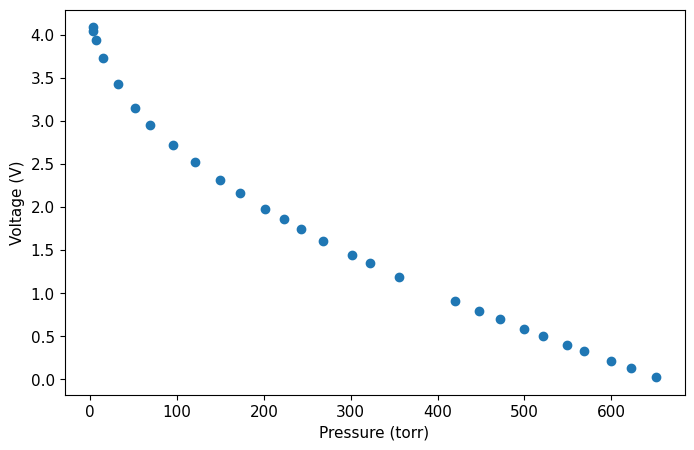

In [6]:
# You code this

fig, ax = plt.subplots(figsize = (8,5))

ax.scatter(df['Presssure (torr)'], df['Voltage (V)'])
ax.set_xlabel('Pressure (torr)')
ax.set_ylabel('Voltage (V)')


## Make a magnet calibration function

Write a function that will convert the transition location in volts to field in gauss.  The Polynomial fit function is shown in the legend of the plot.

**Note:** The data are collected in the direction of **decreasing current** (normal to superconducting transition).

![Magnet calibration data and fit](magnet_cal_2024.png)

In [7]:
## Make your calibration function.

## Then test it

coeffs = [16.9383, 80.8228, 0.4954, -0.1859]

def I2B(I, Cn=coeffs):
    '''
    Magnet calibration functionfor arbitrary polynomial length.
    Assumes that lowest index is constant term.
    '''
    # You code this
    result = 0

    for index, value in enumerate(coeffs):
      result += value * I**index

    return result


Overlay the conversion function on the calibration data.

## Apply the magnet calibration

Convert the transition locations to magnetic field.

In [8]:
# Add a column o your data frame.
# See the examples for how one can do this.

df['B (Gauss)'] = df['Voltage (V)'].apply(I2B)

df.head()

,Presssure (torr),Voltage (V),B (Gauss)
0,651.8,0.025516,19.000894
1,622.4,0.131926,27.609124
2,599.3,0.216429,34.452018
3,568.0,0.331342,43.765914
4,548.9,0.404004,49.659635


## If using [ITS-90 coefficients](https://courses.washington.edu/phys431/superconductivity/ITS-1990_McGlashan_JChemThermo_1990.pdf), make a temperature function

Skip this step if you already have found the temperature from the online calculator or old look-up table.

Otherwise build a function that converts pressure to temperature from the following formula:

$$T/\text{K} = A_0 + \sum_{i=1}^{8} A_i\left[(\ln(p/\text{Pa})-B)/C\right]^i$$

NOTE: Pressure must be converted from torr to pascals!

The coefficients depend on the pressure.  Helium-4 undergoes a normal to superfluid transition at a particular point called the "lambda" point, which is at 31.81661 torr and 2.1768 K.  The vapor pressure curve varies slightly above and below this point.

| Coefficient |  $p$ $<$ 31.81661 torr | $p$ $\ge$ 31.81661 torr |
|    :---:    |        ---: |       ---: |
|    $A_0$    | 1.392408    | 3.146631   |
|    $A_1$    | 0.527153    | 1.357655   |
|    $A_2$    | 0.166756    | 0.413923   |
|    $A_3$    | 0.050988    | 0.091159   |
|    $A_4$    | 0.026514    | 0.016349   |
|    $A_5$    | 0.001975    | 0.001826   |
|    $A_6$    |-0.017976    |-0.004325   |
|    $A_7$    | 0.005409    |-0.004973   |
|    $A_8$    | 0.013259    | 0          |
|    $B$      | 5.6         | 10.3       |
|    $C$      | 2.9         | 1.9        |

Below, create your function and test it by feeding in a few values of pressure and checking the temerature output against the values obtained by the [online calculator from Quantum Design](https://qdusa.com/support/helium_vapor_pressure.html).

Then apply your function to your array of pressures to obtain the corresponding temperatures.  Don't forget!: your measurements may be in volts, not torr, and the coefficients assume that pressure is in pascals.

**ADVICE**

Because of the decision that must be made which coefficients to use, it is tricky to make a fuction that will work on a whole NumPy array. But if you use the Uncertainties package version of the math functions, you can make your function propagate the uncertainty in temperature from an uncertainty in the pressure readings.

SO: Make your function work on single values (possibly with uncertainty), then use the function in a loop to calculate the temperature values, and build an array with these.  (See the example code on GitHub for how to do this.)

In [9]:
# Build a DataFrame or pair of arrays from the coefficients





In [10]:
# Create the function.  The comments in the function body indicate steps to take.

L_coef = [1.392408, 0.527153, 0.166756, 0.050988, 0.026514, 0.001975, -0.017976, 0.005409, 0.013259]
low_B = 5.6
low_C = 2.9

H_coef = [3.146631, 1.357655, 0.413923, 0.091159, 0.016349, 0.001826, -0.004325, -0.004973, 0]
high_B = 10.3
high_C = 1.9


torr_to_pascals_factor = 133.3223684211

def ITS90_p2T(pressure, p_lambda=31.81661, lowP_coeffs=L_coef, hiP_coeffs=H_coef):
    '''
    Convert pressure in torr to temperature in Kelvin from the ITS-90 coefficients and formula.
    This function is NOT NumPy safe, due to the boolean operation needed to choose the coefficients.
    But it can be used with uncertainty objects.
    '''
    # Convert lambda point to Pa
    p_lambda_pa = p_lambda * torr_to_pascals_factor
    # Convert pressure to Pa
    pressure_pa = pressure * torr_to_pascals_factor
    # Make a decision which set of coefficients to use, based on whether
    # the pressure is above or below the lambda point.

    if pressure_pa >= p_lambda_pa:
      coeffs = hiP_coeffs
      B = high_B
      C = high_C
    else:
      coeffs = lowP_coeffs
      B = low_B
      C = low_C

    sum = 0

    for i in range(1,9):
      sum += coeffs[i] * ((np.log(pressure_pa) - B )/ C) ** i
    T = coeffs[0] + sum

    return T

/tmp/ipykernel_855/2282996855.py:39: RuntimeWarning: divide by zero encountered in log
  sum += coeffs[i] * ((np.log(pressure_pa) - B )/ C) ** i
/tmp/ipykernel_855/2282996855.py:39: RuntimeWarning: invalid value encountered in scalar add
  sum += coeffs[i] * ((np.log(pressure_pa) - B )/ C) ** i


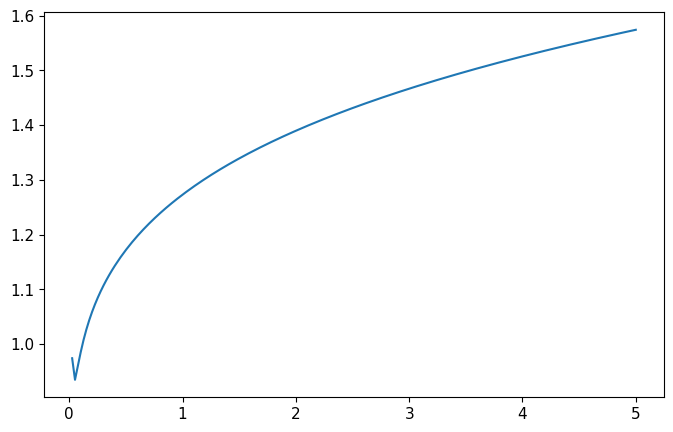

In [11]:
fig, ax = plt.subplots(figsize=(8,5))


pressures = np.linspace(0, 5, 200)


temperatures = [ITS90_p2T(p) for p in pressures]





ax.plot(pressures, temperatures)








In [12]:
df.head()

,Presssure (torr),Voltage (V),B (Gauss)
0,651.8,0.025516,19.000894
1,622.4,0.131926,27.609124
2,599.3,0.216429,34.452018
3,568.0,0.331342,43.765914
4,548.9,0.404004,49.659635


Test your pressure to temperature function.  Feed a few pressure values in, and check the results against the [online calculator from Quantum Design](https://qdusa.com/support/helium_vapor_pressure.html)

In [13]:
# Recommended pressures: 760 torr should give typical BP of liquid helium at 4.2K.
# Lowest pressure of about 3 torr should give near 1.5K.  Check a few points in between as well




### Convert $p$ to $T$

Apply your conversion to the pressure array.  You may need to make a loop to iterate, (unless you know how to deal with boolean operation in NumPy arrays)

In [14]:
# Iterate over the pressure array, and build a new array with np.append()

df['T (K)'] = df['Presssure (torr)'].apply(ITS90_p2T)


df.head()

,Presssure (torr),Voltage (V),B (Gauss),T (K)
0,651.8,0.025516,19.000894,4.062817
1,622.4,0.131926,27.609124,4.016471
2,599.3,0.216429,34.452018,3.979006
3,568.0,0.331342,43.765914,3.926653
4,548.9,0.404004,49.659635,3.893742


## Plot the reduced data set

Plot the data (now in applied field versus temperature, or $H_c$ vs. $T$) so that it mirrors the graph shown in figure 1 of the instructions.  If you see peculiar data points, check for mistakes in transcription or other problems.

Text(0.5, 1.0, 'Temperature vs Applied Magnetic Field')

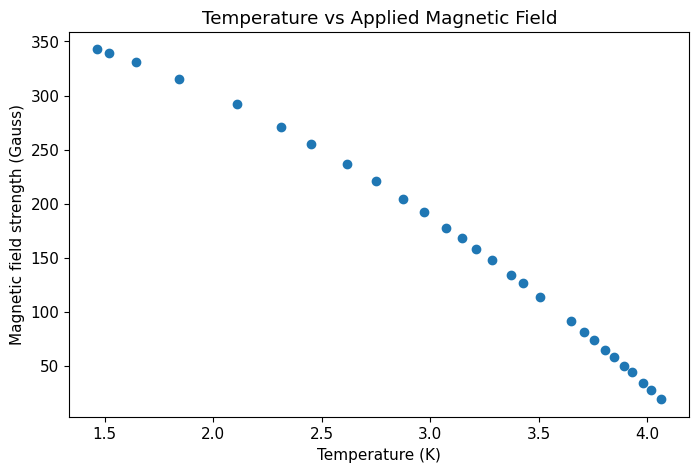

In [15]:
# You code this

fig, ax = plt.subplots(figsize = (8,5))

ax.scatter( df['T (K)'], df['B (Gauss)'])
ax.set_ylabel('Magnetic field strength (Gauss)')
ax.set_xlabel('Temperature (K)')
ax.set_title('Temperature vs Applied Magnetic Field')



## Linearize the data

Rescale the data so that the relationship between the <i>x</i> and <i>y</i> values is linear.  Use equation (1) in the instructions as a guide:

$$H_c(T) = H_{c0}\left[1 - \left(\frac{T}{T_c}\right)^2\right]\quad\quad\quad\quad\quad(1)$$

Then plot the results to confirm.

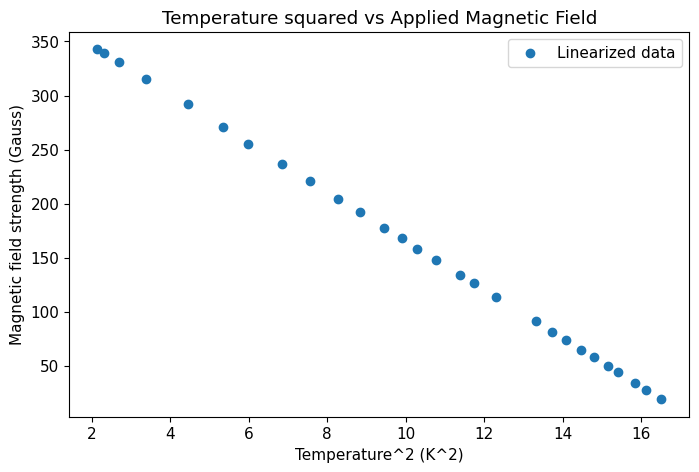

In [16]:
## Take the temperature values and square them
## Example from DataFrame: uT2 = Hg_data['T_90']*Hg_data['T_90']

df['Squared Temperature (K^2)'] = df['T (K)']**2



# Then plot the results.  You should see a pretty good straight line.

fig, ax = plt.subplots(figsize = (8,5))

ax.scatter(df['Squared Temperature (K^2)'], df['B (Gauss)'], label = 'Linearized data')
ax.set_ylabel('Magnetic field strength (Gauss)')
ax.set_xlabel('Temperature^2 (K^2)')
ax.set_title('Temperature squared vs Applied Magnetic Field')
ax.legend()



## Fit the linearized data

Obtain the slope and intercept, plus uncertainty.

In [17]:
# You code this

from lmfit.models import LinearModel

linear_model = LinearModel()

ydata = df['B (Gauss)']
xdata = df['Squared Temperature (K^2)']

param_guess = linear_model.guess(xdata, ydata)

linear_model_fit = linear_model.fit(ydata, param_guess, x=xdata)


linear_fit_params = linear_model_fit.params


linear_fit_slope_with_error = unc.ufloat(linear_fit_params['slope'].value, linear_fit_params['slope'].stderr)
linear_fit_intercept_with_error = unc.ufloat(linear_fit_params['intercept'].value, linear_fit_params['intercept'].stderr)



## Make a nice big, clear plot

Calculate the fit line from eval() and make a large plot, with a grid, data-points with error bars and the fit line on top of the data.  Make sure the fit line goes through both axes so that you can read the critical fiels and critical temperature-squared directly from the plot.

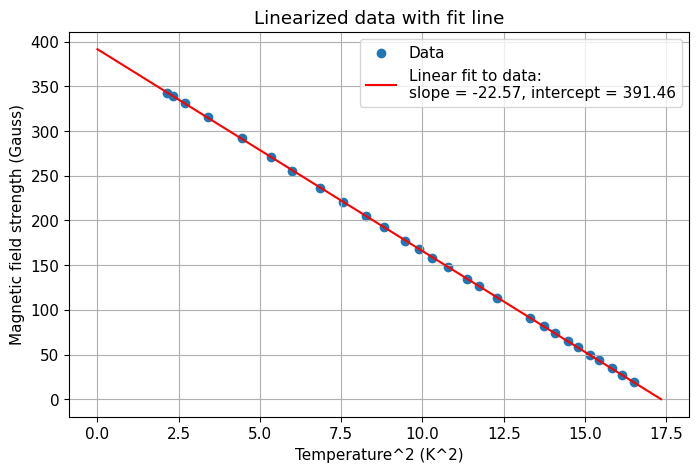

In [18]:
## Make a big plot. Show the fit line going all the way

linear_fit_slope = linear_fit_params['slope'].value
linear_fit_intercept =  linear_fit_params['intercept'].value


fig, ax = plt.subplots(figsize=(8,5))

xmin = 0
xmax = -1 * linear_fit_intercept / linear_fit_slope
x = np.linspace(xmin, xmax, 1000)


ax.scatter(df['Squared Temperature (K^2)'], df['B (Gauss)'], label='Data')
ax.plot(x, (x* linear_fit_slope + linear_fit_intercept), color = 'r',
        label = f'Linear fit to data:\nslope = {linear_fit_slope:.2f}, intercept = {linear_fit_intercept:.2f}' )

ax.set_ylabel('Magnetic field strength (Gauss)')
ax.set_xlabel('Temperature^2 (K^2)')
ax.set_title('Linearized data with fit line')
ax.grid()
ax.legend()

## Obtain the critical field and temperature

Calculate $H_{c0}$ and $T_c$ from the fit results (with uncertainty).

In [19]:
# You code this.

from uncertainties.umath import sqrt

H_c0_linear = linear_fit_intercept_with_error
T_c_linear = sqrt(-1 * H_c0_linear /linear_fit_slope_with_error)


# print('Results from linearized data fit:')
print('Hc0 = {:.2uP} gauss'.format(H_c0_linear))
print('Tc = {:.2uP} K'.format(T_c_linear))

Hc0 = 391.46±0.21 gauss
Tc = 4.1645±0.0020 K


## Fit the "unlinearized" data

Use the LMFit `Model()` class to create a non-linear fit function in the form of equation (1).  Then use it to fit the unlinearized data of $H_c$ vs. $T$ directly.  In this version, the fit parameters should be the values of $H_{c0}$ vs. $T_c$.  

An example of using the `Model()` class to fit an arbitrary function is given in this notebook: [Example of LMFit Model Custom Function](Example%20LMFit%20Model%20with%20Arbitrary%20Function.ipynb) (The notebook should be in your working subdirectory).

In [20]:
# Follow the example for a nonlinear fitting function in the example notebook.

# You will need to define the function correctly, and also provide staring
# values for the critical tempeature and critical field.
from lmfit import Model


## Define the fit function

def T_vs_H(x, H_c0, T_c):
  return H_c0 * (1 - (x/T_c)**2)


custom_model = Model(T_vs_H)


params = custom_model.make_params(H_c0=H_c0_linear.nominal_value, T_c=T_c_linear.nominal_value)




custom_model_fit = custom_model.fit(df['B (Gauss)'], params, x=df['T (K)'])



custom_fit_params = custom_model_fit.params


custom_fit_H_c0 = custom_fit_params['H_c0']

custom_fit_T_c = custom_fit_params['T_c']


## pull in the Model class and set up the fit

## First argument is the function name.  The others name the
##  adjustable parameters.

## Fit and plot


## Make another big, clear plot

Make a nice plot for this type of fit, similar to what you did above, showing the fit line intersecting both axes.

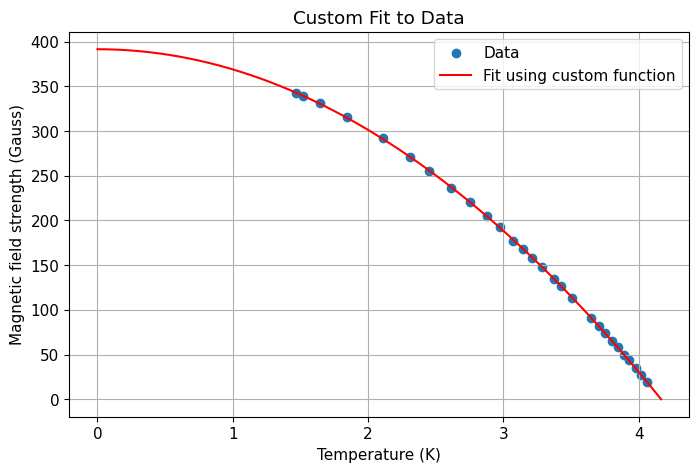

In [21]:
## Make a big plot


## Make a big plot. Show the fit line going all the way




fig, ax = plt.subplots(figsize=(8,5))

xmin = 0
xmax = custom_fit_T_c
x = np.linspace(xmin, xmax, 1000)
y = T_vs_H(x, H_c0=custom_fit_H_c0, T_c=custom_fit_T_c)

ax.scatter(df['T (K)'], df['B (Gauss)'], label='Data')
ax.plot(x, y, color = 'r', label='Fit using custom function')

ax.set_ylabel('Magnetic field strength (Gauss)')
ax.set_xlabel('Temperature (K)')
ax.set_title('Custom Fit to Data')
ax.grid()
ax.legend()




## Compare the fit results

Compare the fit results from both procedures to each other: do they agree within their uncertainty?  Do the fit results agree with handbook or text values?  Print the all in a single table for easy comparison.

In [22]:
T_c_custom_fit_with_uncertainty = unc.ufloat(custom_fit_T_c.value, custom_fit_H_c0.stderr)

H_c0_custom_fit_with_uncertainty = unc.ufloat(custom_fit_H_c0.value, custom_fit_H_c0.stderr)



In [23]:
# Example table
#
print('Comparison of fit results:')
print('   Tc (K)   |   Hc0 (G)   ')
print('------------|-------------')
print('{:.2uP} | {:.2uP}     (from linearized data)'.format(T_c_linear,H_c0_linear))
print('{:.2uP} | {:.2uP}     (from nonlinear fit)'.format(T_c_custom_fit_with_uncertainty,H_c0_custom_fit_with_uncertainty))
print('{:8.2f}    | {:.1f}         (handbook)'.format(4.15,410.0))

Comparison of fit results:
   Tc (K)   |   Hc0 (G)   
------------|-------------
4.1645±0.0020 | 391.46±0.21     (from linearized data)
4.16±0.21 | 391.46±0.21     (from nonlinear fit)
    4.15    | 410.0         (handbook)


Hypotheticals graph

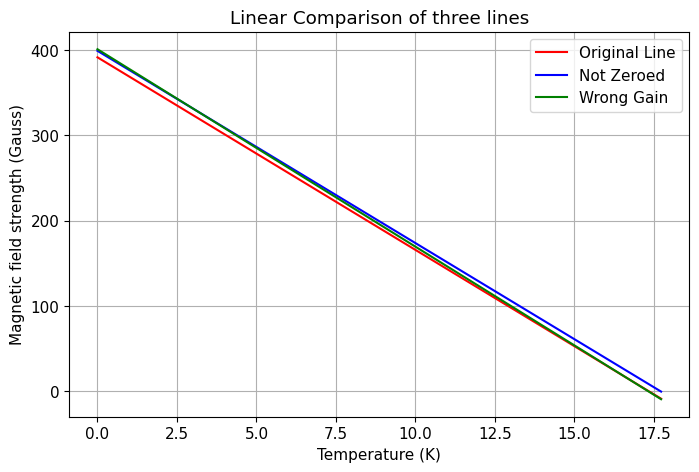

In [24]:


fig, ax = plt.subplots(figsize=(8,5))

xmin = 0
xmax = 4.21 **2
x = np.linspace(xmin, xmax, 1000)
y = T_vs_H(x, H_c0=custom_fit_H_c0, T_c=custom_fit_T_c)


normal_equation = -22.57*x + 391.46

shift_equation = -22.53*x + 399.06

gain_equation = -23.14*x +  400.94



ax.plot(x, normal_equation, color = 'r', label='Original Line')
ax.plot(x, shift_equation, color = 'b', label='Not Zeroed')
ax.plot(x, gain_equation, color='g', label='Wrong Gain')

ax.set_ylabel('Magnetic field strength (Gauss)')
ax.set_xlabel('Temperature (K)')
ax.set_title('Linear Comparison of three lines')
ax.grid()
ax.legend()
# ax.set_xlim(17,18)


In [25]:


fig, axes = plt.subplots(3, figsize=(12,18), constrained_layout=True)

xmin = 0
xmax = 4.21
x = np.linspace(xmin, xmax, 1000)


y_original = T_vs_H(x, T_c=4.16, H_c0=391.46)

y_shifted = T_vs_H(x, T_c=4.158, H_c0=410.7)

y_gain = T_vs_H(x, T_c=4.19, H_c0=391.01)


y_theory = T_vs_H(x, H_c0=410.0  , T_c=4.15 )


for ax in axes: 

    ax.plot(x, y_original, color = 'r', label='Original Line')
    ax.plot(x, y_shifted, color = 'b', label='Not Zeroed')
    ax.plot(x, y_gain, color='g', label='Wrong Gain')

    ax.plot(x, y_theory, color = 'orange', label='Theory')

    ax.set_ylabel('Magnetic field strength (Gauss)')
    ax.set_xlabel('Temperature (K)')
    
    ax.grid()
    ax.legend()

axes[0].set_title('Non Linear Comparison of three lines')


axes[1].set_title('H_c0 closeup')
axes[1].set_xlim(0,0.1)
axes[1].set_ylim(380,415)


axes[2].set_title('T_c closeup')
axes[2].set_xlim(4,4.3)
axes[2].set_ylim(0,10)





(0.0, 10.0)

In [ ]:
391.46 * gain_factor

401.76157894736843

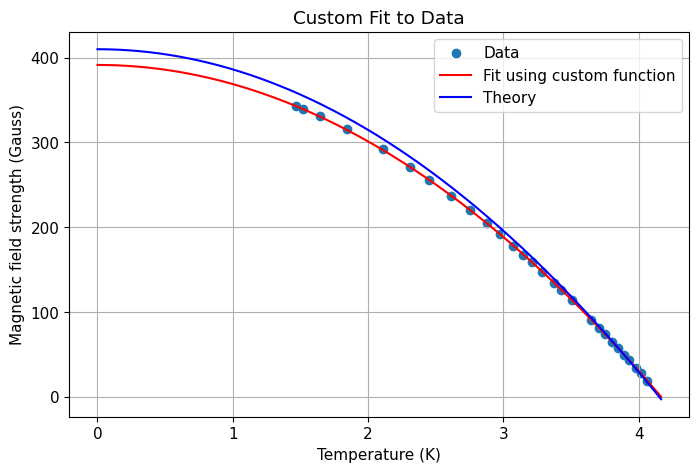

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

xmin = 0
xmax = custom_fit_T_c
x = np.linspace(xmin, xmax, 1000)
y = T_vs_H(x, H_c0=custom_fit_H_c0, T_c=custom_fit_T_c)
y_theory = T_vs_H(x, H_c0=410.0  , T_c=4.15 )

ax.scatter(df['T (K)'], df['B (Gauss)'], label='Data')
ax.plot(x, y, color = 'r', label='Fit using custom function')
ax.plot(x, y_theory, color = 'b', label='Theory')





ax.set_ylabel('Magnetic field strength (Gauss)')
ax.set_xlabel('Temperature (K)')
ax.set_title('Custom Fit to Data')
ax.grid()
ax.legend()


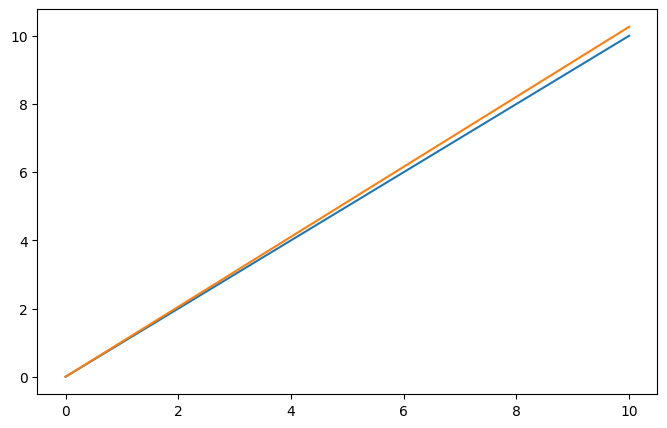

In [ ]:
x = np.linspace(0,10,1000)

fig, ax = plt.subplots(figsize=(8,5))

y_1 = x 
y_2 = 7.8/7.6 * x

ax.plot(x, y_1)
ax.plot(x, y_2)
